In [738]:
import numpy as np
import pandas as pd
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style("white")
import warnings
import time

import scipy as sp
import sklearn
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors
import tensorflow as tf

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree.export import export_text
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, learning_curve, \
ShuffleSplit, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, plot_confusion_matrix, \
average_precision_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.exceptions import ConvergenceWarning

# Data Loading and Preprocessing

In [273]:
# Import dataset

df_raw = pd.read_csv('SarsCoV2.csv', sep=";")
df_raw.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID
0,CHEMBL1200371,FROVATRIPTAN SUCCINATE,0,361.40,0,1.34,Frovatriptan succinate,CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1.O=C(O)CC...,Inhibition index,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303097,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4295411
1,CHEMBL2105345,PROPANIDID,4,337.42,0,2.44,Propanidid,CCCOC(=O)Cc1ccc(OCC(=O)N(CC)CC)c(OC)c1,Inhibition index,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303097,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4295411
2,CHEMBL354541,LOMITAPIDE,4,693.73,2,8.38,Lomitapide,O=C(NC1CCN(CCCCC2(C(=O)NCC(F)(F)F)c3ccccc3-c3c...,Inhibition index,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303097,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4295411
3,CHEMBL4303354,NaN,0,885.10,2,2.90,Acetyl spiramycin,CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]...,Inhibition index,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303097,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4295411
4,CHEMBL1201012,FLURANDRENOLIDE,4,436.52,0,2.50,Flurandrenolide,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,Inhibition index,'=',...,CHEMBL4303835,SARS-CoV-2,Severe acute respiratory syndrome coronavirus 2,ORGANISM,CHEMBL4303097,52,SARS-CoV-2 Screening Data,NaN,2020,CHEMBL4295411


In [274]:
# Get chemical structures and bioactivities and remove irrelevant columns

df_inp = df_raw[['Molecule ChEMBL ID', 'Smiles', 'Standard Value']]
print(df_inp.describe())

       Standard Value
count     1571.000000
mean       505.209861
std       4255.278860
min         -0.444400
25%          0.031060
50%          0.177400
75%          0.537200
max      40000.000000


In [275]:
# Define categories and set cut-off

# Compounds with inhibition index values greater than 1 are considered a hit 

df_inp['Cat'] = df_inp['Standard Value'].apply(lambda x: 1 if x > 1 else 0) 
df_inp.head()

/anaconda3/envs/CHML/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Molecule ChEMBL ID,Smiles,Standard Value,Cat
0,CHEMBL1200371,CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1.O=C(O)CC...,0.2706,0
1,CHEMBL2105345,CCCOC(=O)Cc1ccc(OCC(=O)N(CC)CC)c(OC)c1,0.1570,0
2,CHEMBL354541,O=C(NC1CCN(CCCCC2(C(=O)NCC(F)(F)F)c3ccccc3-c3c...,-0.2950,0
3,CHEMBL4303354,CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]...,1.2760,1
4,CHEMBL1201012,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,-0.0113,0


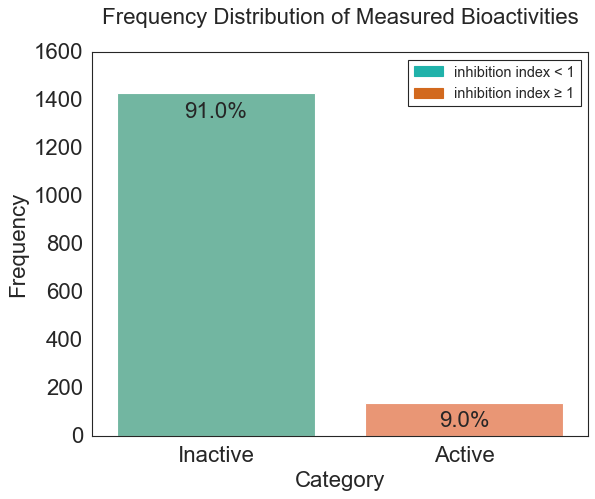

In [277]:
# Plot of data

plot = sns.countplot(x = 'Cat', data = df_inp, palette = 'Set2')
total_count = df_inp.shape[0]
bin_count = df_inp['Cat'].value_counts()
labels = dict(df_inp['Cat'].value_counts())
handles = ['inhibition index < 1', 'inhibition index >= 1']

for k in labels:
    count = labels[k]
    freq = '{:0.1f}%'.format(count/total_count*100)
    plt.text(k, count-100, freq, ha = 'center', fontsize=20)

    
plt.title('Frequency Distribution of Measured Bioactivities\n', fontsize=20)
plot.set_xticklabels(['Inactive','Active'])
label1 = mpatches.Patch(color='lightseagreen', label='inhibition index < 1')
label2 = mpatches.Patch(color='chocolate', label='inhibition index ≥ 1')
plt.legend(handles=[label1, label2], fontsize=13)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Category', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.savefig('ds1_fig1', bbox_inches='tight')

In [278]:
df_inp['Cat'].count()

1571

# Feature Generation Based on Chemical Structures

In [279]:
# Remove rows that are missing chemical structures or SMILES

df_inp.dropna(subset=['Smiles'], inplace = True)
df_inp

/anaconda3/envs/CHML/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Molecule ChEMBL ID,Smiles,Standard Value,Cat
0,CHEMBL1200371,CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1.O=C(O)CC...,0.2706,0
1,CHEMBL2105345,CCCOC(=O)Cc1ccc(OCC(=O)N(CC)CC)c(OC)c1,0.1570,0
2,CHEMBL354541,O=C(NC1CCN(CCCCC2(C(=O)NCC(F)(F)F)c3ccccc3-c3c...,-0.2950,0
3,CHEMBL4303354,CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]...,1.2760,1
4,CHEMBL1201012,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,-0.0113,0
...,...,...,...,...
1566,CHEMBL146980,CCOC(=O)CC(=O)N1CCSC1COc1ccccc1OC,0.3830,0
1567,CHEMBL1761,Cl.OC(CCN1CCCC1)(c1ccccc1)C1CCCCC1,0.7878,0
1568,CHEMBL1704116,CC(C)(C)NC[C@@H](O)COc1cccc2c1CCCC2=O.Cl,0.8131,0
1569,CHEMBL1435413,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,40000.0000,1


# Calculate molecular descriptors

In [280]:
# Calculate molecular descriptors

desc_types = [x[0] for x in Descriptors._descList]

print('There are {} descriptors to be calculated.'.format(len(desc_types)))

def calc_descriptors(smile, desc_type):
    """
    Input: a single SMILES and a single descriptor type
    Output: descriptor for a single chemical structure
    """
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([desc_type]) # Define a descriptor calculator
    
    desc = calc.CalcDescriptors(Chem.MolFromSmiles(smile)) # Calculate descriptor

    return desc[0]

There are 200 descriptors to be calculated.


In [10]:
# Add computed descriptors to existing dataframe as new columns

for dt in desc_types:
    df_inp[dt] = df_inp.Smiles.apply(lambda x: calc_descriptors(x, dt))

/anaconda3/envs/CHML/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [281]:
df_inp

,Molecule ChEMBL ID,Smiles,Standard Value,Cat
0,CHEMBL1200371,CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1.O=C(O)CC...,0.2706,0
1,CHEMBL2105345,CCCOC(=O)Cc1ccc(OCC(=O)N(CC)CC)c(OC)c1,0.1570,0
2,CHEMBL354541,O=C(NC1CCN(CCCCC2(C(=O)NCC(F)(F)F)c3ccccc3-c3c...,-0.2950,0
3,CHEMBL4303354,CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]...,1.2760,1
4,CHEMBL1201012,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,-0.0113,0
...,...,...,...,...
1566,CHEMBL146980,CCOC(=O)CC(=O)N1CCSC1COc1ccccc1OC,0.3830,0
1567,CHEMBL1761,Cl.OC(CCN1CCCC1)(c1ccccc1)C1CCCCC1,0.7878,0
1568,CHEMBL1704116,CC(C)(C)NC[C@@H](O)COc1cccc2c1CCCC2=O.Cl,0.8131,0
1569,CHEMBL1435413,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,40000.0000,1


In [12]:
# Export calculated molecular descriptors as .csv

df_inp.to_csv('SarsCoV2_descriptors.csv')

In [810]:
# Load molecular descriptors as new dataframe

df = pd.read_csv('SarsCoV2_descriptors.csv')
df.head()

,Unnamed: 0,Molecule ChEMBL ID,Smiles,Standard Value,Cat,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,CHEMBL1200371,CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1.O=C(O)CC...,0.2706,0,11.254750,-1.076481,11.254750,0.296296,0.542151,...,0,0,0,0,0,0,0,0,0,0
1,1,CHEMBL2105345,CCCOC(=O)Cc1ccc(OCC(=O)N(CC)CC)c(OC)c1,0.1570,0,11.989998,-0.273812,11.989998,0.045706,0.613651,...,0,0,0,0,0,0,0,0,0,0
2,2,CHEMBL354541,O=C(NC1CCN(CCCCC2(C(=O)NCC(F)(F)F)c3ccccc3-c3c...,-0.2950,0,13.716096,-4.532206,13.716096,0.077313,0.129689,...,0,0,0,0,0,0,0,0,1,0
3,3,CHEMBL4303354,CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]...,1.2760,1,13.440349,-1.486566,13.440349,0.029280,0.190698,...,0,0,0,0,0,0,0,0,0,0
4,4,CHEMBL1201012,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,-0.0113,0,15.479612,-1.353940,15.479612,0.045706,0.691028,...,0,0,0,0,0,0,0,0,0,0



# Calculate molecular fingerprints

,Unnamed: 0,Molecule ChEMBL ID,Smiles,Standard Value,Cat,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,ROMol
0,0,CHEMBL1200371,CN[C@@H]1CCc2[nH]c3ccc(C(N)=O)cc3c2C1.O=C(O)CC...,0.2706,0,11.254750,-1.076481,11.254750,0.296296,0.542151,...,0,0,0,0,0,0,0,0,0,
1,1,CHEMBL2105345,CCCOC(=O)Cc1ccc(OCC(=O)N(CC)CC)c(OC)c1,0.1570,0,11.989998,-0.273812,11.989998,0.045706,0.613651,...,0,0,0,0,0,0,0,0,0,
2,2,CHEMBL354541,O=C(NC1CCN(CCCCC2(C(=O)NCC(F)(F)F)c3ccccc3-c3c...,-0.2950,0,13.716096,-4.532206,13.716096,0.077313,0.129689,...,0,0,0,0,0,0,0,1,0,
3,3,CHEMBL4303354,CO[C@@H]1[C@@H](O[C@@H]2O[C@H](C)[C@@H](O[C@H]...,1.2760,1,13.440349,-1.486566,13.440349,0.029280,0.190698,...,0,0,0,0,0,0,0,0,0,
4,4,CHEMBL1201012,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,-0.0113,0,15.479612,-1.353940,15.479612,0.045706,0.691028,...,0,0,0,0,0,0,0,0,0,

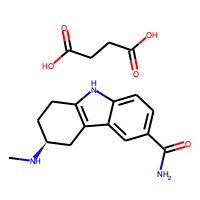
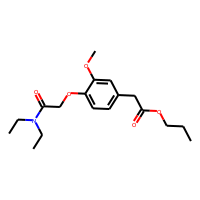
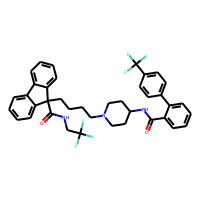
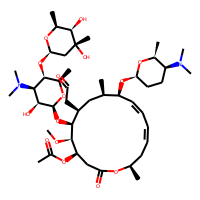
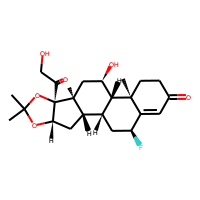

In [282]:
# Generate molecular fingerprint descriptors part 1: convert SMILES to molecular structure

PandasTools.AddMoleculeColumnToFrame(df, smilesCol='Smiles')
df.head()

In [123]:
# Generate molecular fingerprint descriptors part 2: convert structure to fingerprint vectors

mfp2_fps = rdFingerprintGenerator.GetFPs(list(df['ROMol']))
FPS = []

# Convert fingerprint vectors to numpy arrays

for fp in mfp2_fps:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    FPS.append(arr)
    
print('There are {} morgan fingerprint bits.'.format(len(FPS[0])))

There are 2048 morgan fingerprint bits.


# Model Building

In [608]:
# Compare performance using two different sets of features

X_desc = df.drop(['Unnamed: 0', 'Molecule ChEMBL ID', 'Smiles', 'Cat', 'ROMol', 'Standard Value'], axis = 1)
X_desc.fillna(0, inplace = True)

scaler = StandardScaler()
X_desc_scaled = scaler.fit_transform(X_desc)
X_fp = FPS

y = df['Cat']

In [473]:
# Define function to plot learning curves for all algorithms
# Taken from https://scikit-learn.org/stable/_downloads/ea2857380c5e032728a259b30f8e8582/plot_learning_curve.py

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title, fontsize=20)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples", fontsize=20)
    axes[0].set_ylabel("Score", fontsize=20)

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,scoring='balanced_accuracy',
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    print('Balanced accuracy:', round(np.mean(test_scores[-1]), 3))
    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best", fontsize=14)

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples", fontsize=20)
    axes[1].set_ylabel("fit_times", fontsize=20)
    axes[1].set_title("Scalability of the model", fontsize=20)
    
    print('Fit time: {} seconds'.format(np.mean(fit_times[-1])))

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times", fontsize=20)
    axes[2].set_ylabel("Score", fontsize=20)
    axes[2].set_title("Performance of the model", fontsize=20)

    return plt

## Decision Tree Classifier

### Morgan fingerprints as features

0.735


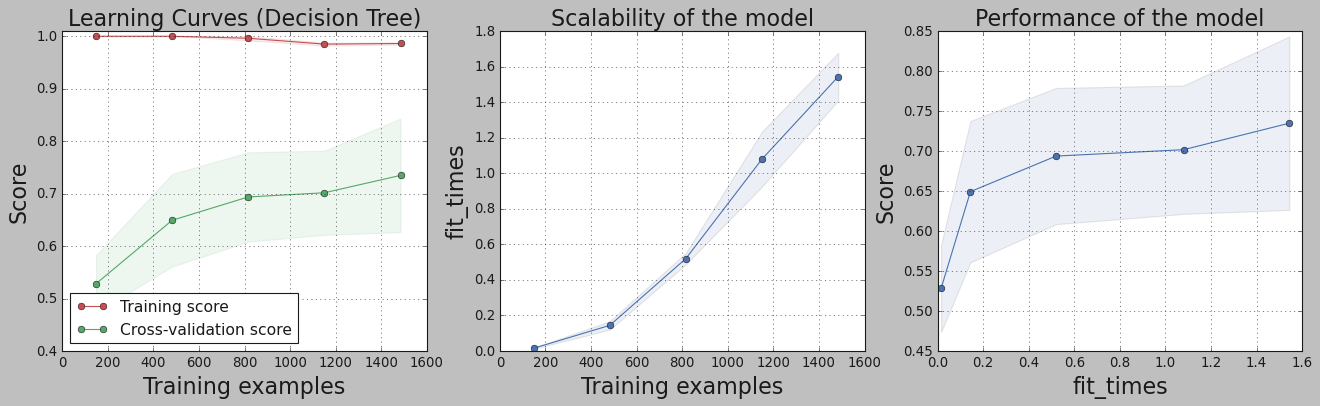

In [435]:
# Plot learning curve for decision tree classifier with default settings

mpl.style.use('classic')
title = "Learning Curves (Decision Tree)"

# Cross validation with 20 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

estimator = DecisionTreeClassifier(random_state=0)
lc = plot_learning_curve(estimator, title, X_fp, y, ylim=(0.4, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds1_tree_fig2', bbox_inches='tight')

plt.show()

Balanced prediction accuracy: 0.742
F1 score: 0.517
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1423
           1       0.50      0.54      0.52       140

    accuracy                           0.91      1563
   macro avg       0.73      0.74      0.73      1563
weighted avg       0.91      0.91      0.91      1563

tn: 1348 
fp: 75 
fn: 65 
tp: 75


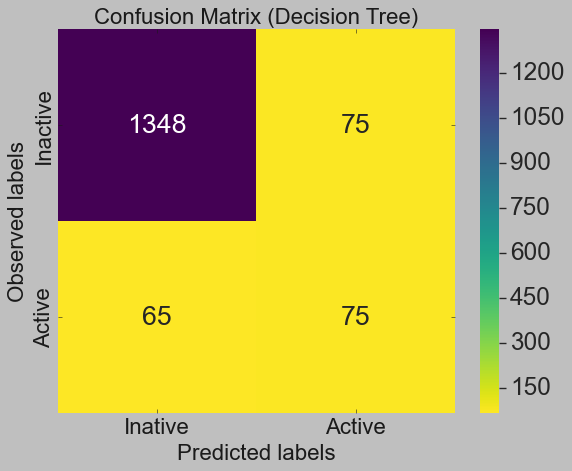

In [724]:
# Initialize the decision tree classifier

tree = DecisionTreeClassifier(random_state=0, ccp_alpha=0)

# Fit the model
start = time.time()
predict = cross_val_predict(tree, X_fp, y, cv=20)
print('Balanced prediction accuracy:', round(balanced_accuracy_score(y, predict), 3))
print('F1 score:', round(f1_score(y, predict), 3))
print(classification_report(y, predict))
tn, fp, fn, tp = confusion_matrix(y, predict).ravel()
print('tn:', tn, 
      '\nfp:', fp,
      '\nfn:', fn, 
      '\ntp:', tp)

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
 
ax.set_xlabel('Predicted labels', fontsize=20);
ax.set_ylabel('Observed labels', fontsize=20);

ax.set_title('Confusion Matrix (Decision Tree)', fontsize=20);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Inative', 'Active']);
ax.yaxis.set_ticklabels(['Inactive', 'Active']);
plt.savefig('ds1_tree_fig3', bbox_inches='tight')
plt.show()

### Molecular descriptors as features

Balanced accuracy: 0.74
Fit time: 0.1025735855102539 seconds


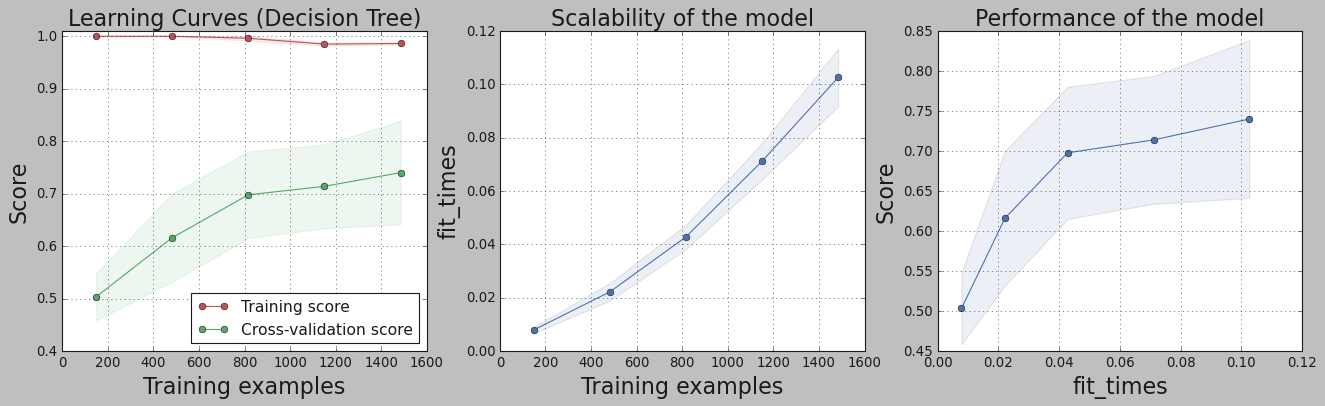

In [615]:
# Plot learning curve for decision tree classifier with default settings
mpl.style.use('classic')

title = "Learning Curves (Decision Tree)"
# Cross validation with 20 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
estimator = DecisionTreeClassifier(random_state=0)
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.4, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds1_tree_fig4', bbox_inches='tight')

plt.show()

Balanced validation accuracy: 0.741
F1 score: 0.472
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      1423
           1       0.41      0.56      0.47       140

    accuracy                           0.89      1563
   macro avg       0.68      0.74      0.70      1563
weighted avg       0.91      0.89      0.89      1563

tn: 1307 
fp: 116 
fn: 61 
tp: 79


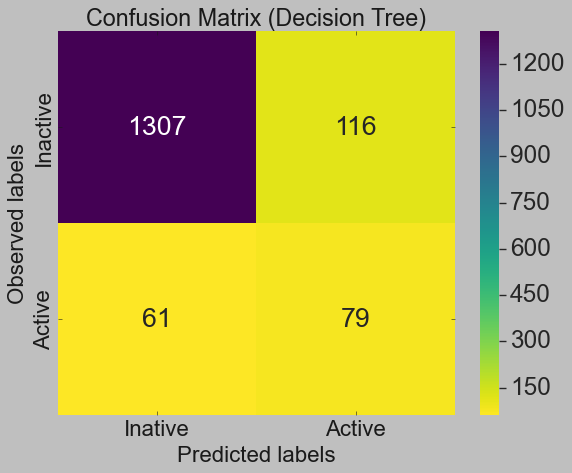

In [616]:
# Initialize the decision tree classifier

tree = DecisionTreeClassifier(random_state=0)

# Take 20% of entire set as validation set
start = time.time
predict = cross_val_predict(tree, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in KNN is {}s.'.format(round(end - start, 3)))
print('Balanced validation accuracy:', round(balanced_accuracy_score(y, predict), 3))
print('F1 score:', round(f1_score(y, predict), 3))
print(classification_report(y, predict))

tn, fp, fn, tp = confusion_matrix(y, predict).ravel()
print('tn:', tn, 
      '\nfp:', fp,
      '\nfn:', fn, 
      '\ntp:', tp)

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (Decision Tree)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust to fit
ax.xaxis.set_ticklabels(['Inative', 'Active']);
ax.yaxis.set_ticklabels(['Inactive', 'Active']);
plt.savefig('ds1_tree_fig5', bbox_inches='tight')
plt.show()

Using molecular descriptors and morgan fingerprints give similar accuracy on the validation set. Will proceed with molecular descriptors as features for decision tree post-pruning.

### Model Complexity Analysis: Post-Pruning

In [617]:
# Decision tree rules
tree = DecisionTreeClassifier(random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_desc, y, test_size=0.20, random_state=0)
tree.fit(X_train, y_train)

tree_rules = export_text(tree, feature_names = list(X_desc.columns))

In [576]:
tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 0,
 'splitter': 'best'}

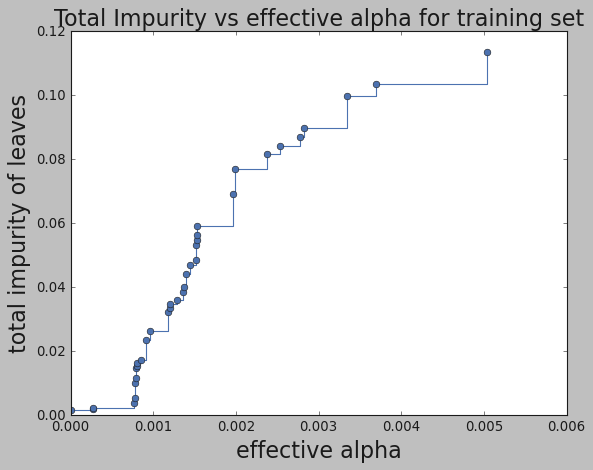

In [567]:
# Implementing cost complexity pruning
mpl.style.use('classic')
path = tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker = 'o', drawstyle = 'steps-post')
ax.set_title('Total Impurity vs effective alpha for training set', fontsize=20)
ax.set_xlabel('effective alpha', fontsize=20)
ax.set_ylabel('total impurity of leaves', fontsize=20);
plt.savefig('ds1_tree_fig6', bbox_inches='tight')

In [443]:
trees = []
for ccp_alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)
    trees.append(tree)
    #print('{} nodes with ccp_alpha {}.'.format(tree.tree_.node_count, ccp_alpha))
    
print('Number of nodes in the last tree is: {} with ccp_alpha: {}'.format(trees[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.00586893726684512


In [802]:
best_model.tree_.node_count

71

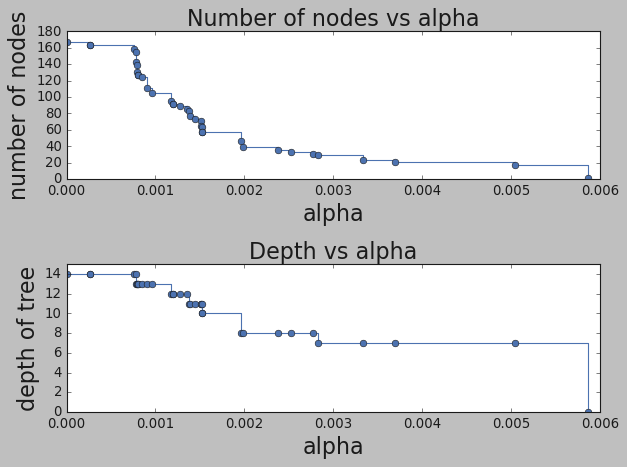

In [444]:
mpl.style.use('classic')

node_counts = [tree.tree_.node_count for tree in trees]
depth = [tree.tree_.max_depth for tree in trees]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker = 'o', drawstyle = 'steps-post')
ax[0].set_xlabel("alpha", fontsize=20)
ax[0].set_ylabel("number of nodes", fontsize=20)
ax[0].set_title("Number of nodes vs alpha", fontsize=20)
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha", fontsize=20)
ax[1].set_ylabel("depth of tree", fontsize=20)
plt.ylim(0,15)
ax[1].set_title("Depth vs alpha", fontsize=20)
fig.tight_layout()
plt.savefig('ds1_tree_fig7', bbox_inches='tight')

In [445]:
len(y_train)

1250

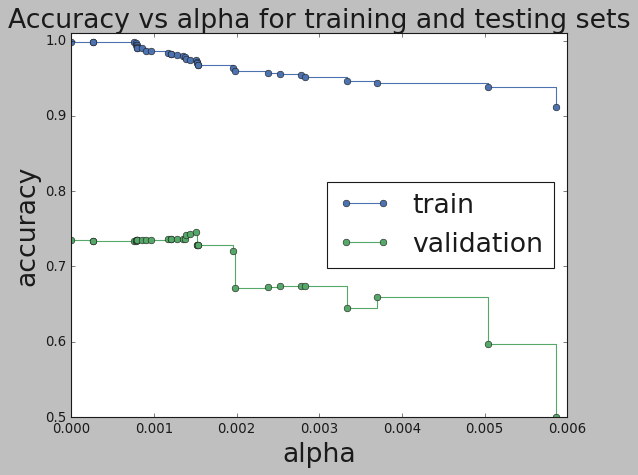

In [450]:
# MC plot: accuracy vs alpha for training and validation
mpl.style.use('classic')
train_scores = [tree.score(X_train, y_train) for tree in trees]

balanced_validation_scores = []
f1_scores = []

for tree in trees:
    predict = tree.predict(X_val)
    balanced_validation_scores.append(balanced_accuracy_score(y_val, predict))
    f1_scores.append(f1_score(y_val, predict))

fig, ax = plt.subplots()
ax.set_title('Accuracy vs alpha for training and testing sets', fontsize=24)
ax.set_xlabel('alpha', fontsize=24)
ax.set_ylabel('accuracy', fontsize=24)
plt.ylim(0.5, 1.01)
ax.plot(ccp_alphas, train_scores, marker = 'o', label = 'train', drawstyle = 'steps-post')
ax.plot(ccp_alphas, balanced_validation_scores, marker = 'o', label = 'validation', drawstyle = 'steps-post')
ax.legend(loc=7, fontsize=24)
plt.savefig('ds1_tree_fig8', bbox_inches='tight')
plt.show()

In [451]:
# Printing results of the best pruned model

index_best_model = np.argmax(balanced_validation_scores)
best_model = trees[index_best_model]
predict = best_model.predict(X_val)
print('Training accuracy:', best_model.score(X_train, y_train),
      '\nValidation accuracy:', round(best_model.score(X_val, y_val), 3),
      '\nBalanced validation accuracy:', round(balanced_accuracy_score(y_val, predict), 3),
      '\nF1 score:', round(f1_score(y_val, predict), 3)
     )

Training accuracy: 0.9736 
Validation accuracy: 0.917 
Balanced validation accuracy: 0.745 
F1 score: 0.552


In [452]:
best_model

DecisionTreeClassifier(ccp_alpha=0.0015111111111111115, random_state=0)

Balanced accuracy: 0.711
Fit time: 0.08940697908401489 seconds


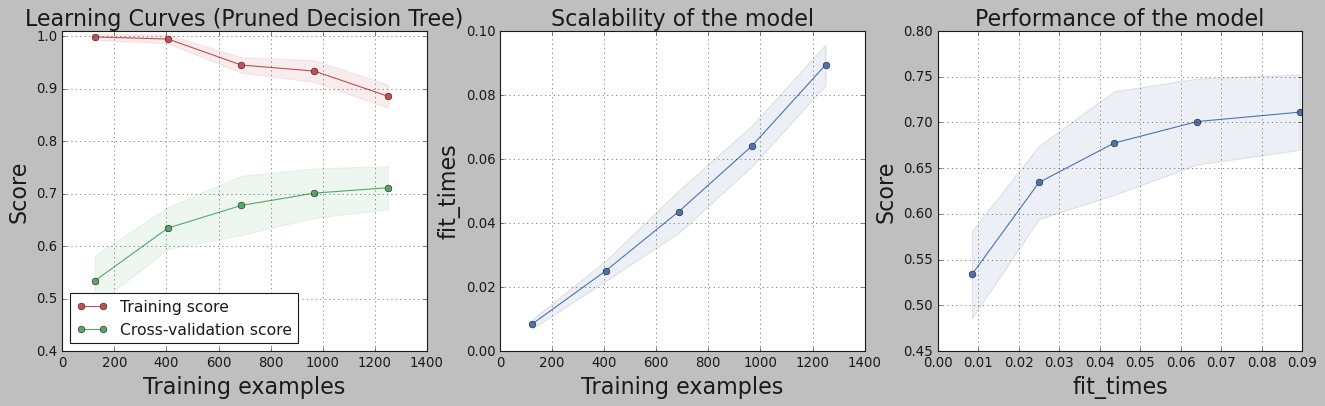

In [475]:
# Plot learning curve for decision tree classifier with post-pruning

mpl.style.use('classic')
title = "Learning Curves (Pruned Decision Tree)"

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

cv = ShuffleSplit(n_splits=20, test_size=0.20, random_state=0)

estimator = best_model
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.4, 1.01),
                    cv=cv, n_jobs=4)
lc.savefig('ds1_tree_fig9', bbox_inches='tight')
plt.show()

Balanced validation accuracy score post-pruning: 0.721
F1 score: 0.491
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1423
           1       0.49      0.49      0.49       140

    accuracy                           0.91      1563
   macro avg       0.72      0.72      0.72      1563
weighted avg       0.91      0.91      0.91      1563



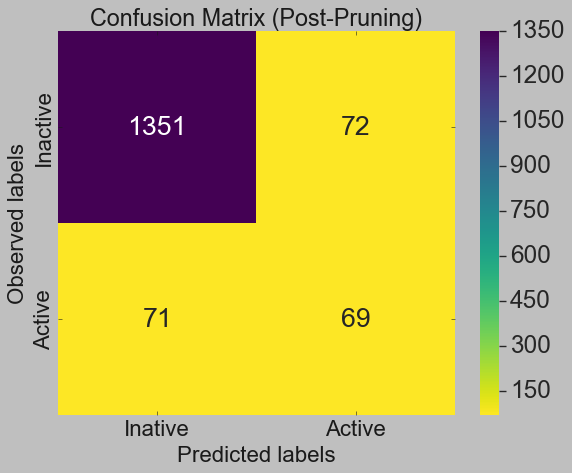

In [455]:
# Confusion matrix post pruning

start = time.time()
predict = cross_val_predict(estimator, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in KNN is {}s.'.format(round(end - start, 3)))
print('Balanced validation accuracy score post-pruning:', round(balanced_accuracy_score(y, predict), 3))
print('F1 score:', round(f1_score(y, predict), 3))
print(classification_report(y, predict))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (Post-Pruning)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust to fit
ax.xaxis.set_ticklabels(['Inative', 'Active']);
ax.yaxis.set_ticklabels(['Inactive', 'Active']);
plt.savefig('ds1_tree_fig10', bbox_inches='tight')
plt.show()

## Neural Network

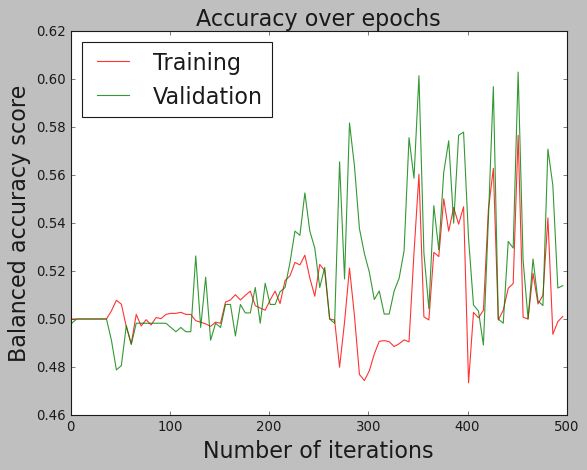

In [767]:
# Plot training/validation performance against number of iterations
mpl.style.use('classic')
mlp = MLPClassifier(random_state=0)

""" Home-made mini-batch learning
"""
X_train,X_val,y_train,y_val = train_test_split(X_desc, y, test_size=0.2)
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 100
N_class = np.unique(y)
scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    #print('epoch: ', epoch)
    mlp.partial_fit(X_train, y_train, N_class)
    # SCORE TRAIN
    scores_train.append(balanced_accuracy_score(y_train, mlp.predict(X_train)))

    # SCORE TEST
    scores_test.append(balanced_accuracy_score(y_val, mlp.predict(X_val)))

    epoch += 1

iters = range(1,N_EPOCHS * 5, 5)
""" Plot """
plt.plot(iters,scores_train, color='red', alpha=0.8, label='Training')
plt.plot(iters,scores_test, color='green', alpha=0.8, label='Validation')
plt.title("Accuracy over epochs", fontsize=20)
plt.xlabel('Number of iterations', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.savefig('ds1_nn_fig0', bbox_inches='tight')
plt.show()

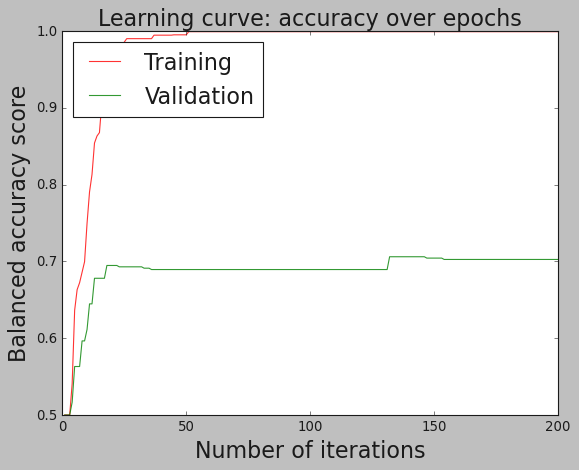

In [796]:
# Plot training/validation performance against number of iterations
mpl.style.use('classic')
estimator = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, activation='relu', 
                    solver='adam', learning_rate_init=0.001, random_state=0)

""" Home-made mini-batch learning
"""
X_train,X_val,y_train,y_val = train_test_split(X_fp, y, test_size=0.2)
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 200
N_class = np.unique(y)
scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    #print('epoch: ', epoch)
    estimator.partial_fit(X_train, y_train, N_class)
    # SCORE TRAIN
    scores_train.append(balanced_accuracy_score(y_train, estimator.predict(X_train)))

    # SCORE TEST
    scores_test.append(balanced_accuracy_score(y_val, estimator.predict(X_val)))

    epoch += 1

iters = range(1,N_EPOCHS+1)
""" Plot """
plt.plot(iters,scores_train, color='red', alpha=0.8, label='Training')
plt.plot(iters,scores_test, color='green', alpha=0.8, label='Validation')
plt.title("Learning curve: accuracy over epochs", fontsize=20)
plt.xlabel('Number of iterations', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.savefig('ds1_nn_fig0', bbox_inches='tight')
plt.show()

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  %

Clock time for 20-fold cross_val_predict in KNN is 46.162s.
Balanced validation accuracy: 0.744
F1 score: 0.599
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1423
           1       0.73      0.51      0.60       140

    accuracy                           0.94      1563
   macro avg       0.84      0.74      0.78      1563
weighted avg       0.93      0.94      0.93      1563



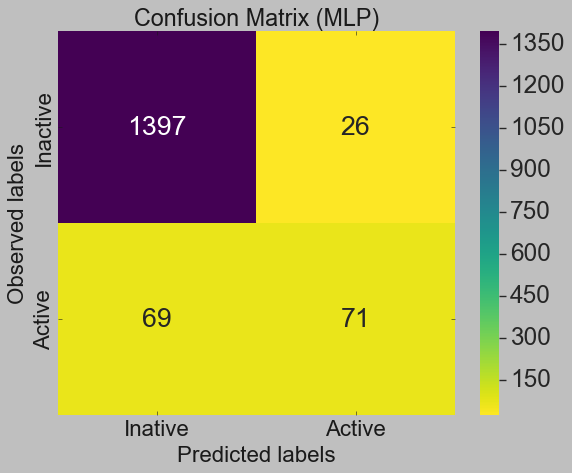

In [797]:
# Confusion matrix with default settings
estimator = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50, activation='relu', 
                    solver='adam', learning_rate_init=0.001, random_state=0)

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_fp, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in KNN is {}s.'.format(round(end - start, 3)))
print('Balanced validation accuracy:', round(balanced_accuracy_score(y, predict), 3))
print('F1 score:', round(f1_score(y, predict), 3))
print(classification_report(y, predict))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (MLP)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust to fit
ax.xaxis.set_ticklabels(['Inative', 'Active']);
ax.yaxis.set_ticklabels(['Inactive', 'Active']);
plt.savefig('ds1_nn_fig2', bbox_inches='tight')
plt.show()

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


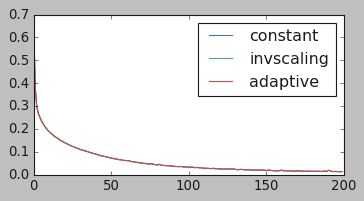

In [537]:
mpl.style.use('classic')
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))

learn_rate = ['constant', 'invscaling', 'adaptive']
for lr in learn_rate:
    mlp = MLPClassifier(random_state=0, max_iter=200, learning_rate=lr)
    mlp.fit(X_desc_scaled, y)
    ax.plot(mlp.loss_curve_)
plt.legend(learn_rate)

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


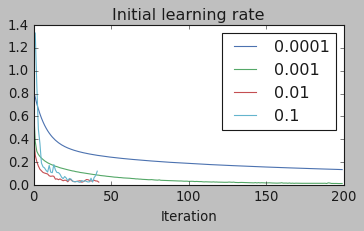

In [727]:
mpl.style.use('classic')
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))

learn_rate_init = [0.0001, 0.001, 0.01, 0.1]
for i in learn_rate_init:
    mlp = MLPClassifier(random_state=0, max_iter=200, learning_rate_init=i)
    mlp.fit(X_desc_scaled, y)
    ax.plot(mlp.loss_curve_)
plt.legend(learn_rate_init)
plt.title('Initial learning rate')
plt.xlabel('Iteration')
plt.savefig('ds1_nn_fig6', bbox_inches='tight')

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

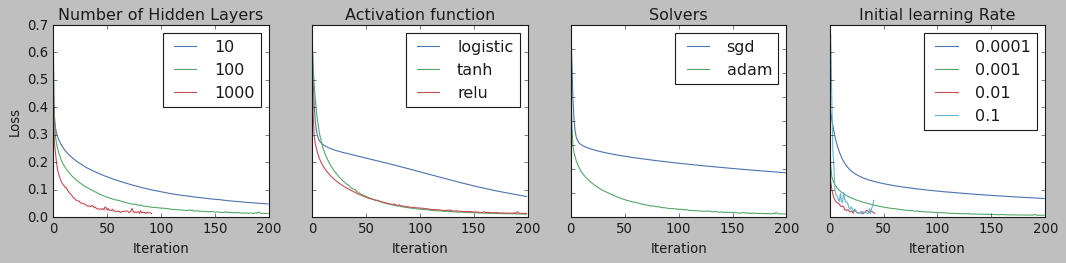

In [729]:
# MC plots: number of hidden layers, activation functions, and solvers

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
sizes = [10, 100, 1000]
for s in sizes:
    mlp = MLPClassifier(random_state=0, max_iter=200, hidden_layer_sizes=s)
    mlp.fit(X_desc_scaled, y)
    axes[0].plot(mlp.loss_curve_, label='hidden_layer_size='+str(s))
axes[0].legend(sizes)
#axes[0].title('Number of Hidden Layers')

#test activation function
acts = ['logistic', 'tanh', 'relu']
for a in acts:
    mlp = MLPClassifier(random_state=0, max_iter=200, activation=a)
    mlp.fit(X_desc_scaled, y)
    axes[1].plot(mlp.loss_curve_, label='a')
axes[1].legend(acts)
#axes[1].title('Activation function')

#test solvers
solvers = ['sgd','adam']
for s in solvers:
    mlp = MLPClassifier(random_state=0, max_iter=200, solver = s)
    mlp.fit(X_desc_scaled, y)
    axes[2].plot(mlp.loss_curve_, label=s)
axes[2].legend(solvers)

learn_rate_init = [0.0001, 0.001, 0.01, 0.1]
for i in learn_rate_init:
    mlp = MLPClassifier(random_state=0, max_iter=200, learning_rate_init=i)
    mlp.fit(X_desc_scaled, y)
    axes[3].plot(mlp.loss_curve_)
axes[3].legend(learn_rate_init)

#axes[2].title('Solvers')
axes[0].set_title('Number of Hidden Layers')
axes[1].set_title('Activation function')
axes[2].set_title('Solvers')
axes[3].set_title('Initial learning Rate')

for ax in axes:
    ax.set(xlabel='Iteration', ylabel='Loss')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes:
    ax.label_outer()

plt.savefig('ds1_nn_fig3', bbox_inches='tight')

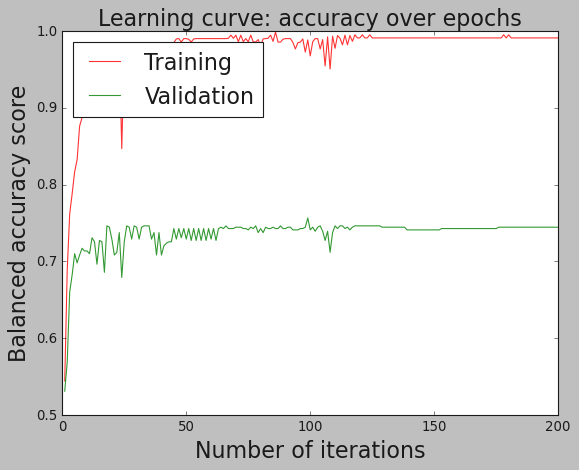

In [793]:
# Plot training/validation performance against number of iterations
mpl.style.use('classic')
estimator = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, activation='relu', 
                    solver='adam', learning_rate_init=0.01, random_state=0)

""" Home-made mini-batch learning
"""
X_train,X_val,y_train,y_val = train_test_split(X_desc_scaled, y, test_size=0.2)
N_TRAIN_SAMPLES = X_train.shape[0]
N_EPOCHS = 200
N_class = np.unique(y)
scores_train = []
scores_test = []

# EPOCH
epoch = 0
while epoch < N_EPOCHS:
    #print('epoch: ', epoch)
    estimator.partial_fit(X_train, y_train, N_class)
    # SCORE TRAIN
    scores_train.append(balanced_accuracy_score(y_train, estimator.predict(X_train)))

    # SCORE TEST
    scores_test.append(balanced_accuracy_score(y_val, estimator.predict(X_val)))

    epoch += 1

iters = range(1,N_EPOCHS+1)
""" Plot """
plt.plot(iters,scores_train, color='red', alpha=0.8, label='Training')
plt.plot(iters,scores_test, color='green', alpha=0.8, label='Validation')
plt.title("Learning curve: accuracy over epochs", fontsize=20)
plt.xlabel('Number of iterations', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.savefig('ds1_nn_fig6', bbox_inches='tight')
plt.show()

/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/envs/CHML/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  %

Clock time for 20-fold cross_val_predict in MLP is 8.254s.
Balanced validation accuracy: 0.751
F1 score: 0.553
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1423
           1       0.56      0.54      0.55       140

    accuracy                           0.92      1563
   macro avg       0.76      0.75      0.75      1563
weighted avg       0.92      0.92      0.92      1563



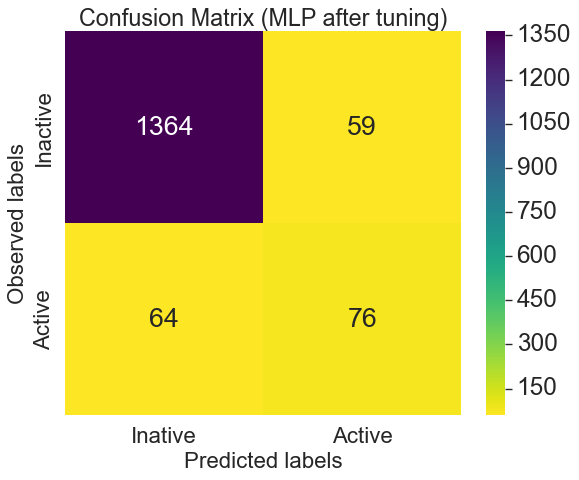

In [790]:
# Confusion matrix after tuning hyperparameters
estimator = MLPClassifier(hidden_layer_sizes=(100,), max_iter=50, activation='relu', 
                    solver='adam', learning_rate_init=0.01, random_state=0)

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_desc_scaled, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in MLP is {}s.'.format(round(end - start, 3)))
print('Balanced validation accuracy:', round(balanced_accuracy_score(y, predict), 3))
print('F1 score:', round(f1_score(y, predict), 3))
print(classification_report(y, predict))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (MLP after tuning)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)  # Adjust to fit
ax.xaxis.set_ticklabels(['Inative', 'Active']);
ax.yaxis.set_ticklabels(['Inactive', 'Active']);
plt.savefig('ds1_nn_fig5', bbox_inches='tight')
plt.show()

## Boosting

Balanced accuracy: 0.629
Fit time: 0.5986613750457763 seconds


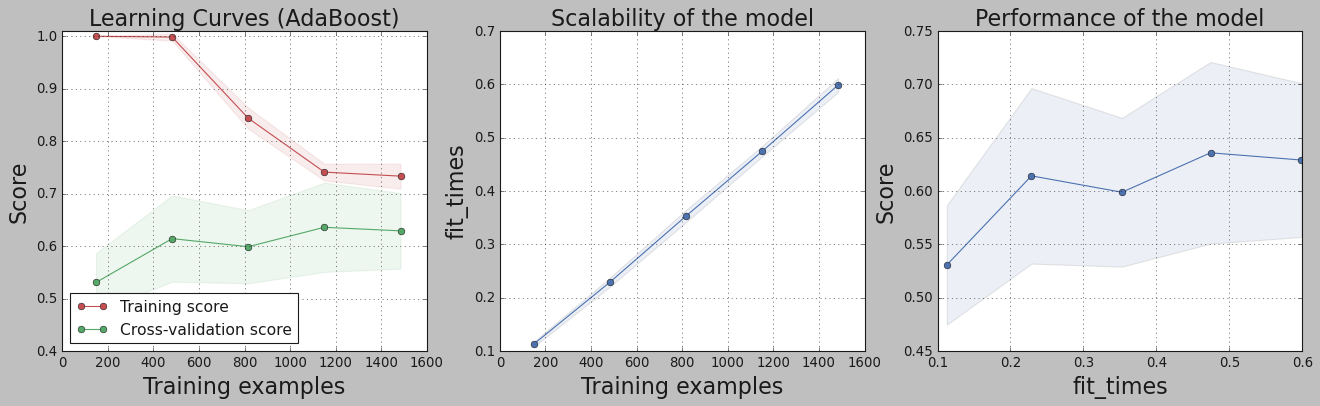

In [655]:
# Plot learning curve for AdaBoost classifier with default settings
mpl.style.use('classic')

title = "Learning Curves (AdaBoost)"

# 20-fold CV

estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=0)
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.4, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds1_adaboost_fig1', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict in KNN is 14.342s.
Balanced validation accuracy: 0.661
F1 score: 0.454
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1423
           1       0.70      0.34      0.45       140

    accuracy                           0.93      1563
   macro avg       0.82      0.66      0.71      1563
weighted avg       0.92      0.93      0.92      1563



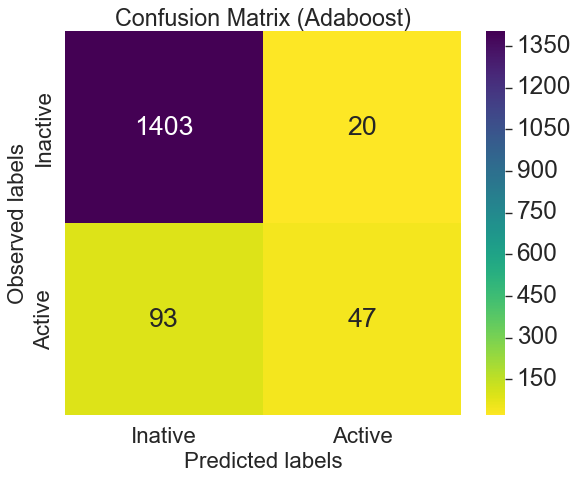

In [732]:
# Confusion matrix with default settings
estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), random_state=0)

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in KNN is {}s.'.format(round(end - start, 3)))
print('Balanced validation accuracy:', round(balanced_accuracy_score(y, predict), 3))
print('F1 score:', round(f1_score(y, predict), 3))
print(classification_report(y, predict))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (Adaboost)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Inative', 'Active']);
ax.yaxis.set_ticklabels(['Inactive', 'Active']);
plt.savefig('ds1_adaboost_fig2', bbox_inches='tight')
plt.show()

In [555]:
estimator.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'gini',
 'base_estimator__max_depth': 1,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__presort': 'deprecated',
 'base_estimator__random_state': None,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(max_depth=1),
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 0}

In [603]:
best_model

DecisionTreeClassifier(ccp_alpha=0.0015111111111111115, random_state=0)

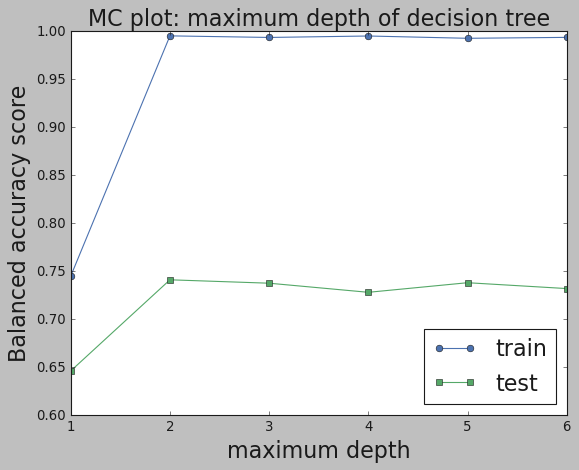

In [751]:
mpl.style.use('classic')

max_depths = [1, 2, 3, 4, 5, 6]
train_score = []
test_score = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)
X_desc = np.array(X_desc)
y = np.array(y)
kf.split(X_desc)

for d in max_depths:
    mean_train_score = 0
    mean_test_score = 0
    for train_index, test_index in kf.split(X_desc):
        estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d), random_state=0)
        X_train, X_val = X_desc[train_index], X_desc[test_index]
        y_train, y_val = y[train_index], y[test_index]
        estimator.fit(X_train, y_train)
        mean_train_score += balanced_accuracy_score(y_train, estimator.predict(X_train))
        mean_test_score += balanced_accuracy_score(y_val, estimator.predict(X_val))
    train_score.append(mean_train_score / 5)
    test_score.append(mean_test_score / 5)
    
plt.plot(max_depths, train_score, 'o-')
plt.plot(max_depths, test_score, 's-')
plt.legend(['train', 'test'], loc=4, fontsize=20)
plt.title('MC plot: maximum depth of decision tree', fontsize=20)
plt.xlabel('maximum depth', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.savefig('ds1_adaboost_fig3', bbox_inches='tight')

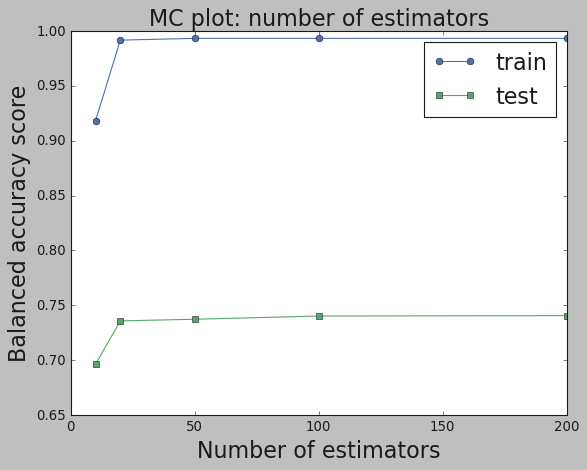

In [658]:
mpl.style.use('classic')

kf = KFold(n_splits=5, shuffle=True, random_state=0)
n_estimators = [10, 20, 50, 100, 200]
train_score = []
test_score = []

for e in n_estimators:
    mean_train_score = 0
    mean_test_score = 0
    for train_index, test_index in kf.split(X_desc):
        estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators=e, random_state=0)
        X_train, X_val = X_desc[train_index], X_desc[test_index]
        y_train, y_val = y[train_index], y[test_index]
        estimator.fit(X_train, y_train)
        mean_train_score += balanced_accuracy_score(y_train, estimator.predict(X_train))
        mean_test_score += balanced_accuracy_score(y_val, estimator.predict(X_val))
    train_score.append(mean_train_score / 5)
    test_score.append(mean_test_score / 5)
    
plt.plot(n_estimators, train_score, 'o-')
plt.plot(n_estimators, test_score, 's-')
plt.legend(['train', 'test'], loc='best', fontsize=20)
plt.title('MC plot: number of estimators', fontsize=20)
plt.xlabel('Number of estimators', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.savefig('ds1_adaboost_fig4', bbox_inches='tight');

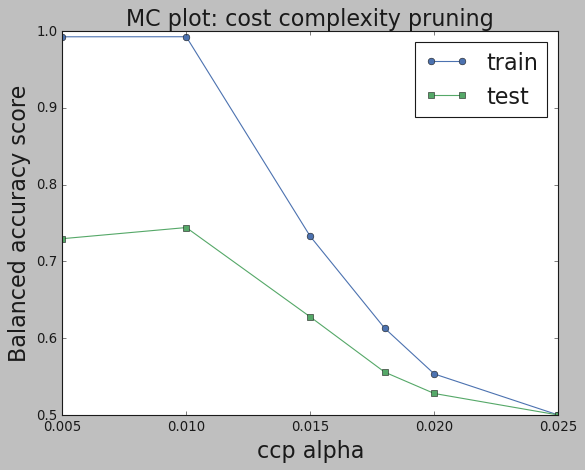

In [755]:
mpl.style.use('classic')
ccp_alphas = [0.005, 0.01,0.015, 0.018, 0.02, 0.025]
train_score = []
test_score = []
kf = KFold(n_splits=5, shuffle=True, random_state=0)

for a in ccp_alphas:
    mean_train_score = 0
    mean_test_score = 0
    for train_index, test_index in kf.split(X_desc):
        estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, ccp_alpha=a))
        X_train, X_val = X_desc[train_index], X_desc[test_index]
        y_train, y_val = y[train_index], y[test_index]
        estimator.fit(X_train, y_train)
        mean_train_score += balanced_accuracy_score(y_train, estimator.predict(X_train))
        mean_test_score += balanced_accuracy_score(y_val, estimator.predict(X_val))
    train_score.append(mean_train_score / 5)
    test_score.append(mean_test_score / 5)
    
plt.plot(ccp_alphas, train_score, 'o-')
plt.plot(ccp_alphas, test_score, 's-')
plt.legend(['train', 'test'], loc='best', fontsize=20)
plt.title('MC plot: cost complexity pruning', fontsize=20)
plt.xlabel('ccp alpha', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.savefig('ds1_adaboost_fig5', bbox_inches='tight');

Balanced accuracy: 0.722
Fit time: 1.0584467053413391 seconds


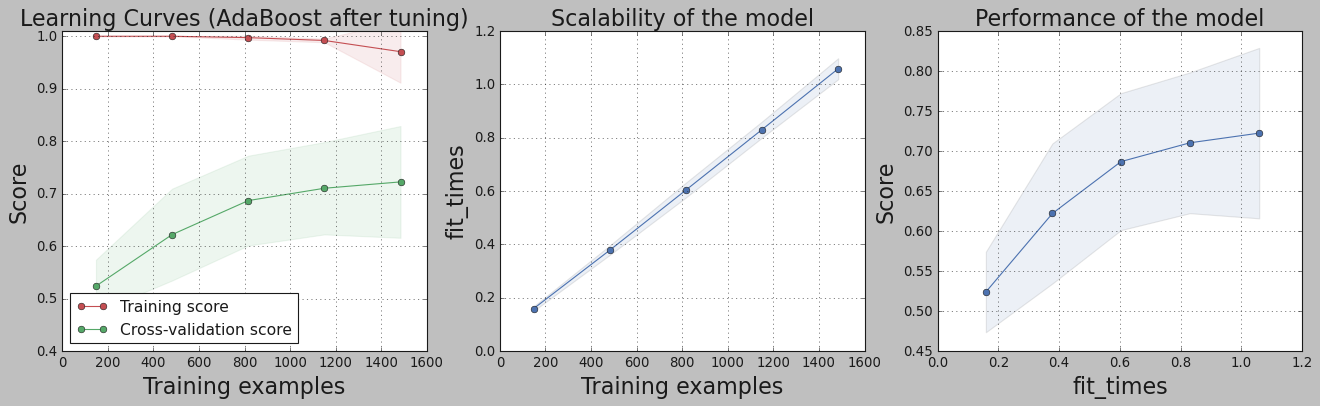

In [756]:
# Plot learning curve for AdaBoost classifier after hyperparameter tuning
mpl.style.use('classic')

title = "Learning Curves (AdaBoost after tuning)"
# Cross validation with 20 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, ccp_alpha=0.01), n_estimators=50, random_state=0)
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.4, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds1_adaboost_fig6', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict for AdaBoost is 19.391s.
Balanced validation accuracy: 0.723
F1 score: 0.532
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1423
           1       0.60      0.48      0.53       140

    accuracy                           0.92      1563
   macro avg       0.77      0.72      0.75      1563
weighted avg       0.92      0.92      0.92      1563



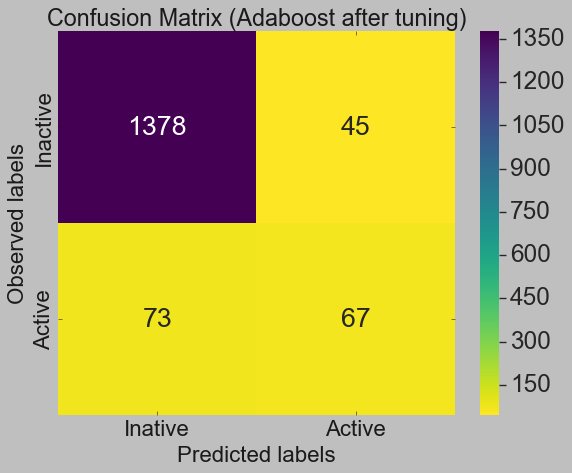

In [757]:
# Confusion matrix after tuning

estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, ccp_alpha=0.01), n_estimators=50, random_state=0)

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict for AdaBoost is {}s.'.format(round(end - start, 3)))
print('Balanced validation accuracy:', round(balanced_accuracy_score(y, predict), 3))
print('F1 score:', round(f1_score(y, predict), 3))
print(classification_report(y, predict))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (Adaboost after tuning)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Inative', 'Active']);
ax.yaxis.set_ticklabels(['Inactive', 'Active']);
plt.savefig('ds1_adaboost_fig7', bbox_inches='tight')
plt.show()

## Support Vector Machines

Balanced accuracy: 0.696
Fit time: 3.312471330165863 seconds


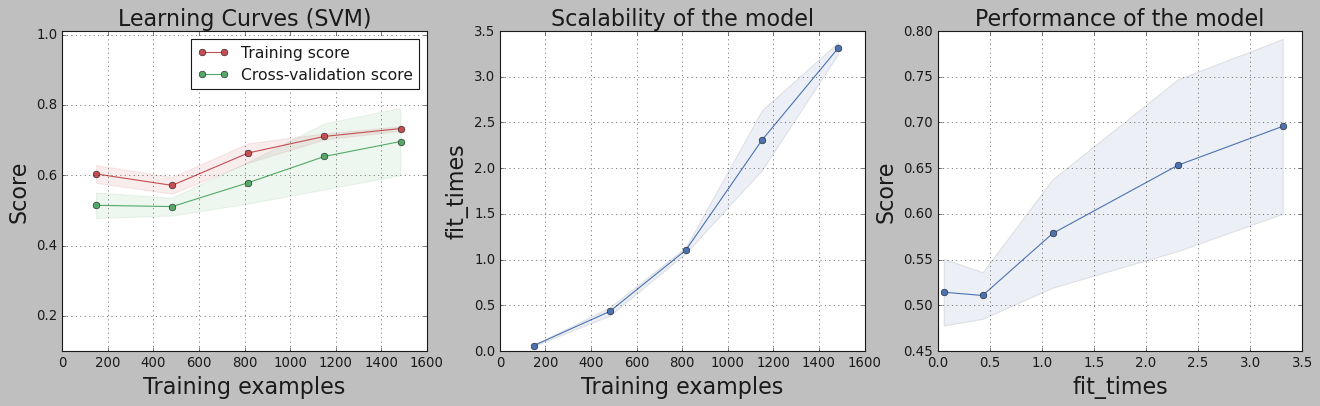

In [807]:
# Plot learning curve for support vector machine classifier with default settings and fingerprint features
mpl.style.use('classic')

title = "Learning Curves (SVM)"
# Cross validation with 20 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

estimator = SVC(random_state=0)
lc = plot_learning_curve(estimator, title, X_fp, y, ylim=(0.1, 1.01),
                    cv=20, n_jobs=4)

lc.savefig('ds1_svm_fig1', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict in KNN is 66.554s.
Balanced validation accuracy: 0.696
F1 score: 0.558
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1423
           1       0.96      0.39      0.56       140

    accuracy                           0.94      1563
   macro avg       0.95      0.70      0.76      1563
weighted avg       0.95      0.94      0.93      1563



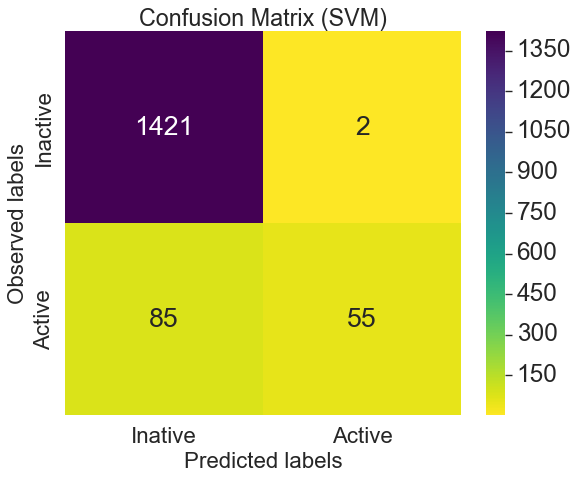

In [734]:
# Confusion matrix with default settings

estimator = SVC(random_state=0)

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_fp, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in KNN is {}s.'.format(round(end - start, 3)))
print('Balanced validation accuracy:', round(balanced_accuracy_score(y, predict), 3))
print('F1 score:', round(f1_score(y, predict), 3))
print(classification_report(y, predict))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (SVM)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Inative', 'Active']);
ax.yaxis.set_ticklabels(['Inactive', 'Active']);
plt.savefig('ds1_svm_fig2', bbox_inches='tight')
plt.show()

In [669]:
estimator.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 0,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

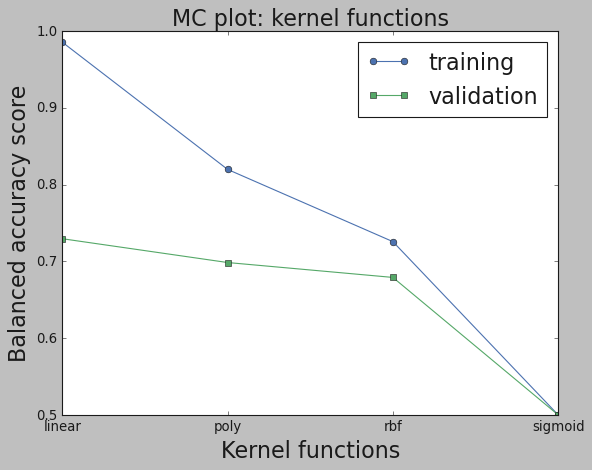

In [723]:
# MC plot: kernel functions

mpl.style.use('classic')
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
kf = KFold(n_splits=5, shuffle=True)
X_fp = np.array(X_fp)
y = np.array(y)
train_score = []
val_score = []
    
for k in kernels:
    mean_train_score = 0
    mean_val_score = 0
    for train_index, val_index in kf.split(X_fp):
        estimator = SVC(kernel=k, degree=3, random_state=0)
        X_train, X_val = X_fp[train_index], X_fp[val_index]
        y_train, y_val = y[train_index], y[val_index]
        estimator.fit(X_train, y_train)
        mean_train_score += balanced_accuracy_score(y_train, estimator.predict(X_train))
        mean_val_score += balanced_accuracy_score(y_val, estimator.predict(X_val))
    train_score.append(mean_train_score / 5)
    val_score.append(mean_val_score / 5)

plt.plot(kernels, train_score, 'o-')
plt.plot(kernels, val_score, 's-')
plt.legend(['training', 'validation'], loc='best', fontsize=20)
plt.title('MC plot: kernel functions', fontsize=20)
plt.xlabel('Kernel functions', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.savefig('ds1_svm_fig3', bbox_inches='tight');

[0.6689230177658407, 0.7785163323880139, 0.8230251030190765, 0.8246891534391535, 0.8239295002981581]
[0.5965060128283597, 0.7138292475833695, 0.7042723122637481, 0.7182092305751311, 0.7047778785113307]


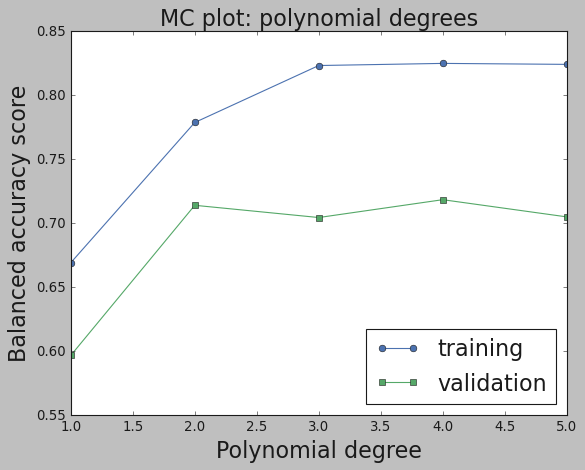

In [690]:
# MC plot: degree of the polynomial kernel function (‘poly’)
# Compare different degrees of polynomial kernel and training/test scores

mpl.style.use('classic')
degrees = [1, 2, 3, 4, 5]
kf = KFold(n_splits=5, shuffle=True)
X_fp = np.array(X_fp)
y = np.array(y)
train_scores = []
val_scores = []

for d in degrees:
    mean_train_score = 0
    mean_val_score = 0
    for train_index, val_index in kf.split(X_fp):
        X_train, X_val = X_fp[train_index], X_fp[val_index]
        y_train, y_val = y[train_index], y[val_index]
        estimator = SVC(kernel='poly', degree=d, random_state=0)
        estimator.fit(X_train, y_train)
        mean_train_score += balanced_accuracy_score(y_train, estimator.predict(X_train))
        mean_val_score += balanced_accuracy_score(y_val, estimator.predict(X_val))

    train_scores.append(mean_train_score / 5)
    val_scores.append(mean_val_score / 5)
    
print(train_scores)
print(val_scores)

plt.plot(degrees, train_scores, 'o-')
plt.plot(degrees, val_scores, 's-')
plt.legend(['training', 'validation'], loc='best', fontsize=20)
plt.title('MC plot: polynomial degrees', fontsize=20)
plt.xlabel('Polynomial degree', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.savefig('ds1_svm_fig4', bbox_inches='tight');

[0.5472434175250829, 0.6404681741976376, 0.7216415913026083, 0.8186700035877438, 0.9515464763452952, 0.9809666804075032]
[0.5295698924731183, 0.592355889656814, 0.6581419419632769, 0.71656520111691, 0.7346149072359113, 0.7312484895132128]


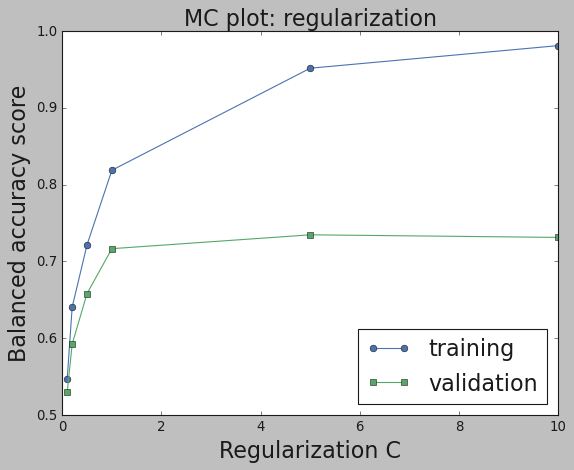

In [809]:
# MC plot: degree of the polynomial kernel function (‘poly’)
# Compare different degrees of polynomial kernel and training/test scores

mpl.style.use('classic')
C = [0.1, 0.2, 0.5, 1, 5, 10]
kf = KFold(n_splits=5, shuffle=True)
X_fp = np.array(X_fp)
y = np.array(y)
train_scores = []
val_scores = []

for c in C:
    mean_train_score = 0
    mean_val_score = 0
    for train_index, val_index in kf.split(X_fp):
        X_train, X_val = X_fp[train_index], X_fp[val_index]
        y_train, y_val = y[train_index], y[val_index]
        estimator = SVC(kernel='poly', C=c, random_state=0)
        estimator.fit(X_train, y_train)
        mean_train_score += balanced_accuracy_score(y_train, estimator.predict(X_train))
        mean_val_score += balanced_accuracy_score(y_val, estimator.predict(X_val))

    train_scores.append(mean_train_score / 5)
    val_scores.append(mean_val_score / 5)
    
print(train_scores)
print(val_scores)

plt.plot(C, train_scores, 'o-')
plt.plot(C, val_scores, 's-')
plt.legend(['training', 'validation'], loc='best', fontsize=20)
plt.title('MC plot: regularization', fontsize=20)
plt.xlabel('Regularization C', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.savefig('ds1_svm_fig4_2', bbox_inches='tight');

Balanced accuracy: 0.716
Fit time: 3.071262800693512 seconds


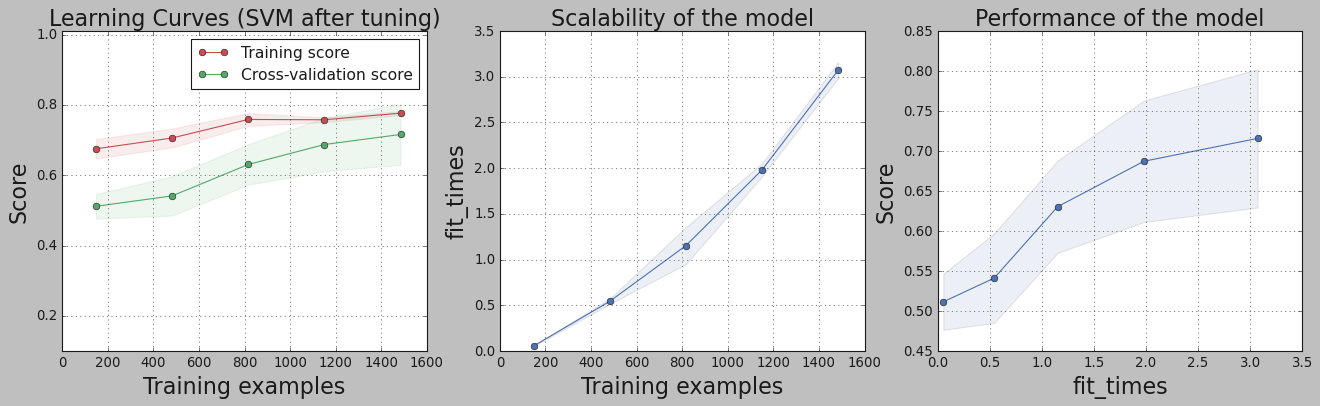

In [691]:
# Plot learning curve for support vector machine classifier after tuning
mpl.style.use('classic')

title = "Learning Curves (SVM after tuning)"
# Cross validation with 20 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

estimator = SVC(kernel='poly', degree=2, random_state=0)
lc = plot_learning_curve(estimator, title, X_fp, y, ylim=(0.1, 1.01),
                    cv=20, n_jobs=4)

lc.savefig('ds1_svm_fig5', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict in KNN is 58.711s.
Balanced validation accuracy: 0.716
F1 score: 0.589
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1423
           1       0.91      0.44      0.59       140

    accuracy                           0.95      1563
   macro avg       0.93      0.72      0.78      1563
weighted avg       0.94      0.95      0.94      1563



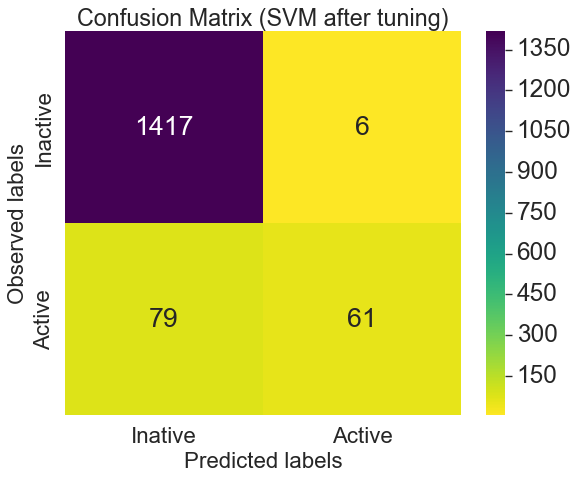

In [800]:
# Confusion matrix after tuning

estimator = SVC(kernel='poly', degree=2, random_state=0)

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_fp, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in KNN is {}s.'.format(round(end - start, 3)))
print('Balanced validation accuracy:', round(balanced_accuracy_score(y, predict), 3))
print('F1 score:', round(f1_score(y, predict), 3))
print(classification_report(y, predict))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (SVM after tuning)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Inative', 'Active']);
ax.yaxis.set_ticklabels(['Inactive', 'Active']);
plt.savefig('ds1_svm_fig6', bbox_inches='tight')
plt.show()

Balanced accuracy: 0.546
Fit time: 0.2950634121894836 seconds


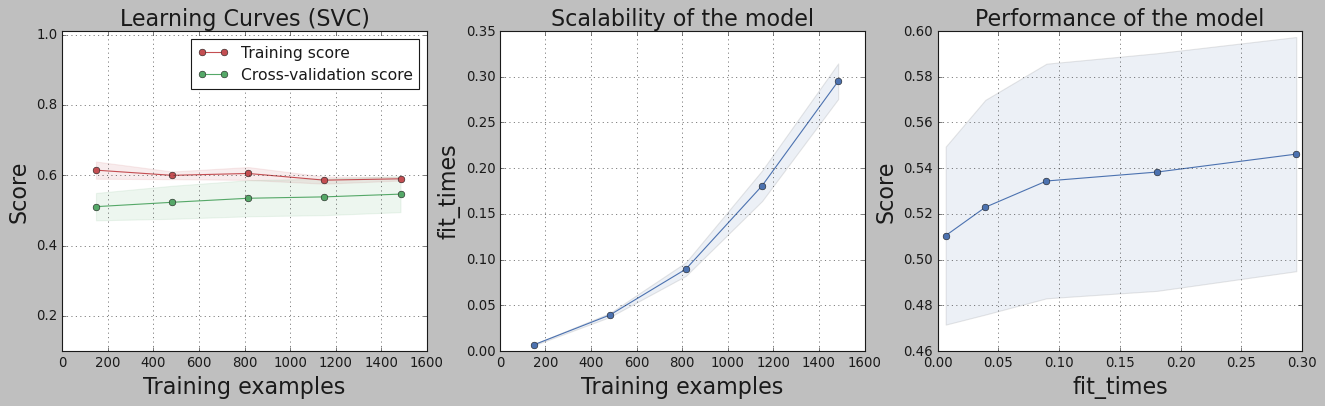

In [795]:
# Plot learning curve for support vector machine classifier with default settings and scaled molecular descriptors
mpl.style.use('classic')
Scaler = StandardScaler()
X_desc_scaled = Scaler.fit_transform(X_desc_scaled)

title = "Learning Curves (SVC)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
estimator = SVC(kernel='poly', degree=4, random_state=0)
plot_learning_curve(estimator, title, X_desc_scaled, y, ylim=(0.1, 1.01),
                    cv=20, n_jobs=4)

plt.show()

## k-Nearest Neighbors

Balanced accuracy: 0.684
Fit time: 0.020216715335845948 seconds


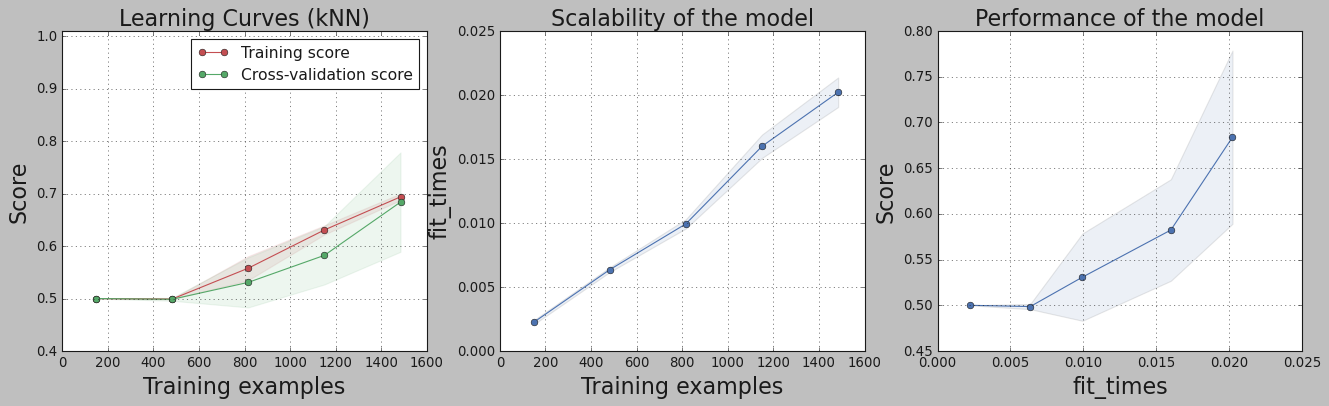

In [718]:
# Plot learning curve for support vector machine classifier with default settings
mpl.style.use('classic')
title = "Learning Curves (kNN)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
estimator = KNeighborsClassifier()
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.4, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds1_kNN_fig1', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict in KNN is 0.504s.
Balanced validation accuracy: 0.684
F1 score: 0.463
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      1423
           1       0.55      0.40      0.46       140

    accuracy                           0.92      1563
   macro avg       0.75      0.68      0.71      1563
weighted avg       0.91      0.92      0.91      1563



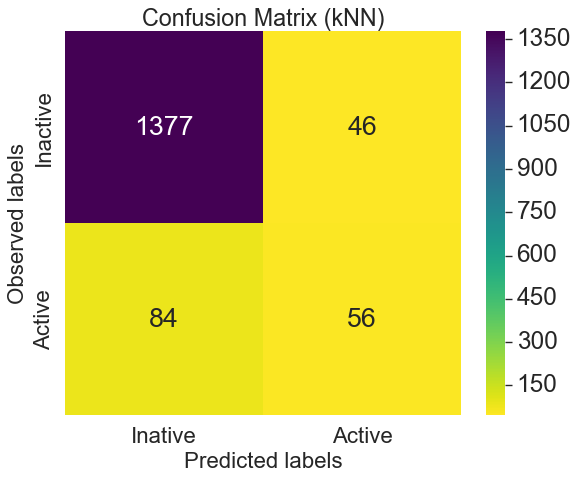

In [722]:
# Confusion matrix with default settings

estimator = KNeighborsClassifier()

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in KNN is {}s.'.format(round(end - start, 3)))
print('Balanced validation accuracy:', round(balanced_accuracy_score(y, predict), 3))
print('F1 score:', round(f1_score(y, predict), 3))
print(classification_report(y, predict))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (kNN)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Inative', 'Active']);
ax.yaxis.set_ticklabels(['Inactive', 'Active']);
plt.savefig('ds1_kNN_fig2', bbox_inches='tight')
plt.show()

In [707]:
estimator.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

Balanced accuracy: 0.694
Fit time: 0.23335661888122558 seconds


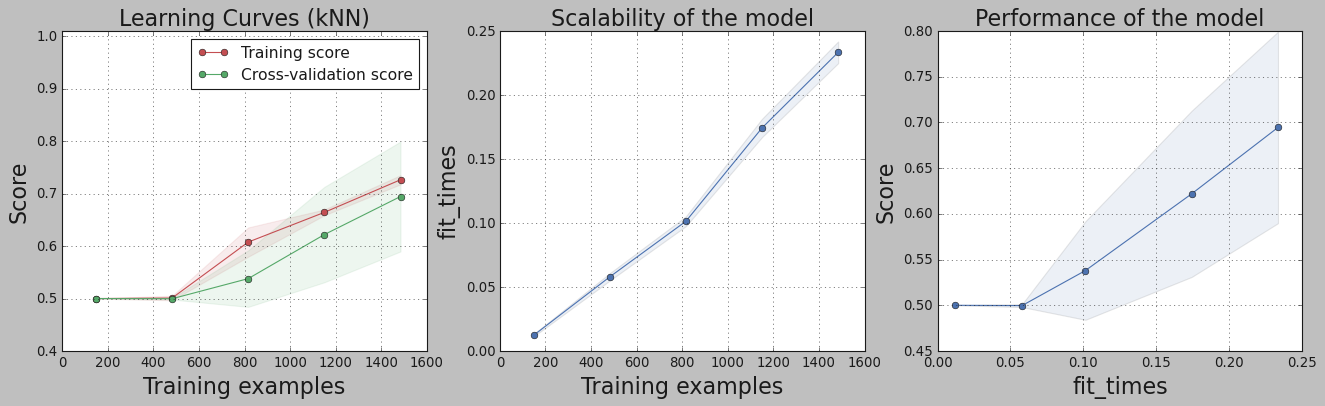

In [689]:
# Plot learning curve for support vector machine classifier with default settings
# Features: Morgan fingerprints

mpl.style.use('classic')
title = "Learning Curves (kNN)"
# 20-fold CV
estimator = KNeighborsClassifier()
lc = plot_learning_curve(estimator, title, X_fp, y, ylim=(0.4, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds1_kNN_fig#', bbox_inches='tight')
plt.show()

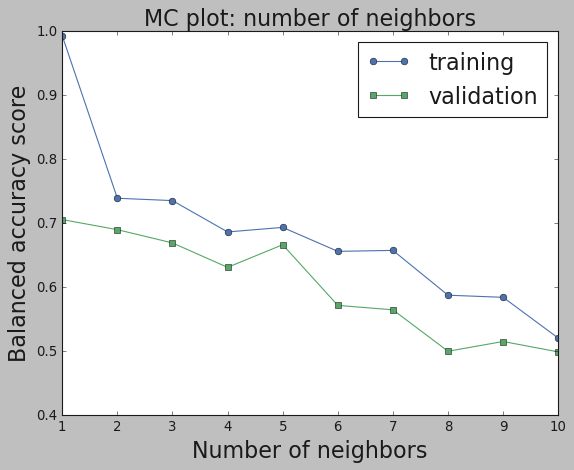

In [697]:
# MC plot: number of neighbors

mpl.style.use('classic')
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
kf = KFold(n_splits=5, shuffle=True)
X_desc = np.array(X_desc)
y = np.array(y)
train_scores = []
val_scores = []

for n in n_neighbors:
    mean_train_score = 0
    mean_val_score = 0
    for train_index, val_index in kf.split(X_desc):
        X_train, X_val = X_desc[train_index], X_desc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        estimator = KNeighborsClassifier(n_neighbors=n)
        estimator.fit(X_train, y_train)
        mean_train_score += balanced_accuracy_score(y_train, estimator.predict(X_train))
        mean_val_score += balanced_accuracy_score(y_val, estimator.predict(X_val))

    train_scores.append(mean_train_score / 5)
    val_scores.append(mean_val_score / 5)
    
plt.plot(n_neighbors, train_scores, 'o-')
plt.plot(n_neighbors, val_scores, 's-')
plt.legend(['training', 'validation'], loc='best', fontsize=20)
plt.title('MC plot: number of neighbors', fontsize=20)
plt.xlabel('Number of neighbors', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.savefig('ds1_knn_fig3', bbox_inches='tight');

Default number of neighbors give the best results.

minkowski
minkowski
minkowski
minkowski
minkowski
euclidean
euclidean
euclidean
euclidean
euclidean
manhattan
manhattan
manhattan
manhattan
manhattan
chebyshev
chebyshev
chebyshev
chebyshev
chebyshev


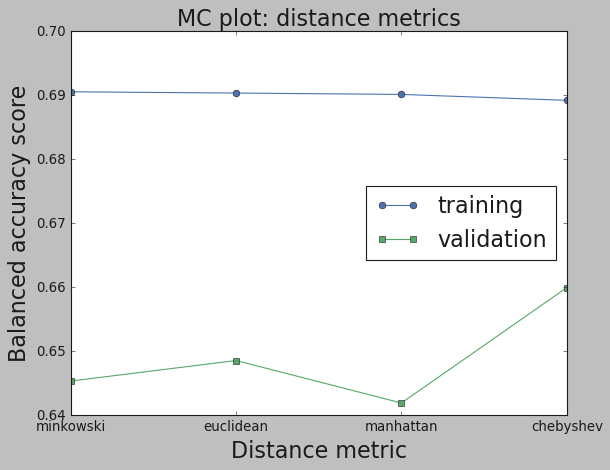

In [715]:
# MC plot: distance metrics

mpl.style.use('classic')
distance = ['minkowski', 'euclidean', 'manhattan', 'chebyshev']
kf = KFold(n_splits=5, shuffle=True)
X_desc = np.array(X_desc)
y = np.array(y)
train_scores = []
val_scores = []

for d in distance:
    mean_train_score = 0
    mean_val_score = 0
    for train_index, val_index in kf.split(X_desc):
        X_train, X_val = X_desc[train_index], X_desc[val_index]
        y_train, y_val = y[train_index], y[val_index]
        estimator = KNeighborsClassifier(metric=d)
        estimator.fit(X_train, y_train)
        mean_train_score += balanced_accuracy_score(y_train, estimator.predict(X_train))
        mean_val_score += balanced_accuracy_score(y_val, estimator.predict(X_val))

    train_scores.append(mean_train_score / 5)
    val_scores.append(mean_val_score / 5)
    
plt.plot(distance, train_scores, 'o-')
plt.plot(distance, val_scores, 's-')
plt.legend(['training', 'validation'], loc='best', fontsize=20)
plt.title('MC plot: distance metrics', fontsize=20)
plt.xlabel('Distance metric', fontsize=20)
plt.ylabel('Balanced accuracy score', fontsize=20)
plt.savefig('ds1_knn_fig4', bbox_inches='tight');

Balanced accuracy: 0.684
Fit time: 0.021419811248779296 seconds


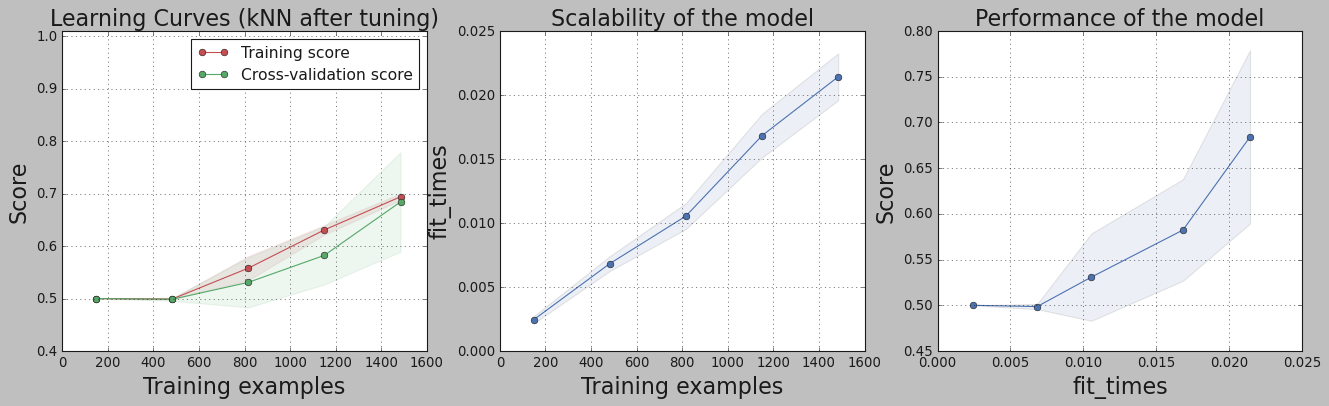

In [758]:
# Plot learning curve for support vector machine classifier after tuning

mpl.style.use('classic')
title = "Learning Curves (kNN after tuning)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
estimator = KNeighborsClassifier(n_neighbors=5, metric='chebyshev')
lc = plot_learning_curve(estimator, title, X_desc, y, ylim=(0.4, 1.01),
                    cv=20, n_jobs=4)
lc.savefig('ds1_kNN_fig5', bbox_inches='tight')
plt.show()

Clock time for 20-fold cross_val_predict in KNN is 0.461s.
Balanced validation accuracy: 0.684
F1 score: 0.465
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1423
           1       0.55      0.40      0.46       140

    accuracy                           0.92      1563
   macro avg       0.75      0.68      0.71      1563
weighted avg       0.91      0.92      0.91      1563



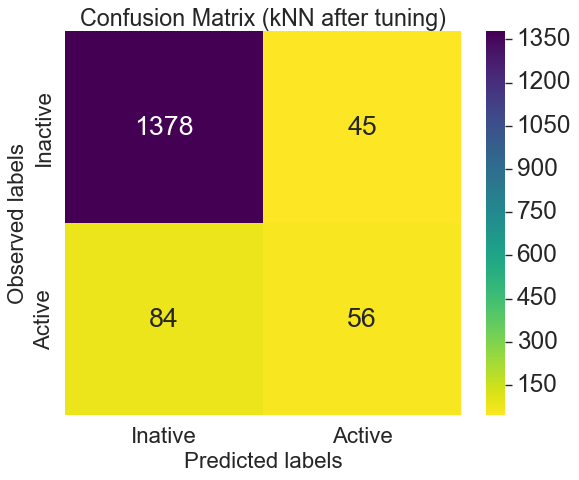

In [721]:
# Confusion matrix after tuning

estimator = KNeighborsClassifier(n_neighbors=5, metric='chebyshev')

# Take 20% of entire set as validation set
start = time.time()
predict = cross_val_predict(estimator, X_desc, y, cv=20)
end = time.time()
print('Clock time for 20-fold cross_val_predict in kNN is {}s.'.format(round(end - start, 3)))
print('Balanced validation accuracy:', round(balanced_accuracy_score(y, predict), 3))
print('F1 score:', round(f1_score(y, predict), 3))
print(classification_report(y, predict))

cm = confusion_matrix(y, predict)

ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, ax=ax, cmap="viridis_r", fmt="g");  

# Labels, title and ticks
label_font = {'size':'20'} 
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'21'}
ax.set_title('Confusion Matrix (kNN after tuning)', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=20)
ax.xaxis.set_ticklabels(['Inative', 'Active']);
ax.yaxis.set_ticklabels(['Inactive', 'Active']);
plt.savefig('ds1_kNN_fig6', bbox_inches='tight')
plt.show()

In [799]:
# Final performance using molecular descriptors

balanced_accuracy = []
f1 = []
run_time = []
model_names = ['Decision Tree', 'MLP', 'AdaBoost', 'SVM', 'kNN']
models = [DecisionTreeClassifier(ccp_alpha=0.0015111111111111115, random_state=0),\
          MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', 
                          learning_rate_init=0.01, random_state=0),\
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, ccp_alpha=0.01), n_estimators=50, random_state=0),\
          SVC(kernel='poly', degree=2, random_state=0),\
          KNeighborsClassifier(n_neighbors=5, metric='chebyshev')]

for model in models:
    start = time.time()
    predict = cross_val_predict(model, X_desc, y, cv=20)
    end = time.time()
    run_time.append(end-start)
    balanced_accuracy.append(balanced_accuracy_score(y, predict))
    f1.append(f1_score(y, predict))
    
df_desc = pd.DataFrame({'Model names':model_names, 'F1 score':f1, 'Balanced Accuracy':balanced_accuracy,\
                     'Run time':run_time})
df_desc.to_csv('./final_performance_desc_SARS-Cov-2.csv', index=False)
df_desc

,Model names,F1 score,Balanced Accuracy,Run time
0,Decision Tree,0.491103,0.721130,2.490560
1,MLP,0.000000,0.496838,4.176143
2,AdaBoost,0.568093,0.745254,32.092104
3,SVM,0.000000,0.500000,1.711179
4,kNN,0.464730,0.684188,0.427601


In [798]:
# Final performance using Morgan fingerprints

balanced_accuracy = []
f1 = []
run_time = []
model_names = ['Decision Tree', 'MLP', 'AdaBoost', 'SVM', 'kNN']
models = [DecisionTreeClassifier(ccp_alpha=0.0015111111111111115, random_state=0),\
          MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', 
                          max_iter=200, learning_rate_init=0.01, random_state=0),\
          AdaBoostClassifier(DecisionTreeClassifier(max_depth=3, ccp_alpha=0.01), n_estimators=50, random_state=0),\
          SVC(kernel='poly', degree=2, random_state=0),\
          KNeighborsClassifier(n_neighbors=5, metric='chebyshev')]

for model in models:
    start = time.time()
    predict = cross_val_predict(model, X_fp, y, cv=20)
    end = time.time()
    run_time.append(end-start)
    balanced_accuracy.append(balanced_accuracy_score(y, predict))
    f1.append(f1_score(y, predict))

print(model_names)
print(f1)
print(balanced_accuracy)
print(run_time)

df_fp = pd.DataFrame({'Model names':model_names, 'F1 score':f1, 'Balanced Accuracy':balanced_accuracy,\
                     'Run time':run_time})
df_fp.to_csv('./final_performance_fp_SARS_Cov-2.csv', index=False)
df_fp

['Decision Tree', 'MLP', 'AdaBoost', 'SVM', 'kNN']
[0.5, 0.5725806451612904, 0.31578947368421056, 0.5893719806763286, 0.5416666666666666]
[0.6901616303583977, 0.7405707258307399, 0.6052078104607971, 0.7157489207910852, 0.6857142857142857]
[17.597704887390137, 37.99238610267639, 103.56097316741943, 61.616172790527344, 10.784619092941284]


,Model names,F1 score,Balanced Accuracy,Run time
0,Decision Tree,0.500000,0.690162,17.597705
1,MLP,0.572581,0.740571,37.992386
2,AdaBoost,0.315789,0.605208,103.560973
3,SVM,0.589372,0.715749,61.616173
4,kNN,0.541667,0.685714,10.784619
